# Cleaning and Preparing Financial Data  

### Description:  
You are a Fintech professional at a leading investment firm, and your team is analyzing the performance of various hedge funds. Your manager has asked you to create a report that provides insights into the funds' performance, but the data is messy and needs to be cleaned and transformed before analysis can begin.

### Tasks:  
- **Fill Missing Returns:** Use the ffill method to fill missing values in the 'Returns' column, assuming that missing values are a result of no trading activity.
- **Normalize Returns Data:** Normalize the 'Returns' data to a range of 0 to 1.
- **Remove Duplicate Rows:** Remove duplicate rows that have the same 'Fund' and 'Date' values.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import sys

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)

Python version 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Pandas version 2.2.1
Numpy version 1.26.4


# The data  

The dataset consists of daily returns data for 100 hedge funds, with additional columns for assets under management, investment strategy, and volatility. The data is messy, with missing values and duplicate rows, and requires cleaning and normalization before analysis can begin.

### Columns:  
- **Fund:** The name of the hedge fund
- **Date:** The trading date (in datetime format)
- **Returns:** The daily returns of the fund with missing values and a large range
- **Assets:** The total assets under management by the fund
- **Strategy:** The investment strategy used by the fund (Equity, Fixed Income, or Multi-Asset)
- **Volatility:** A numeric column representing the annualized standard deviation of each hedge fund's returns, expressed as a percentage.

In [2]:
# set the seed
np.random.seed(0)

# data
data = {
    'Fund': ['Fund {}'.format(i) for i in range(1, 101)],
    'Assets': np.random.randint(low=1000000, high=100000000, size=100),
    'Strategy': np.random.choice(['Equity', 'Fixed Income', 'Multi-Asset'], size=100),
    'Volatility': np.random.uniform(low=0, high=100, size=100),
    'Returns': [np.random.uniform(low=-500, high=500, size=252) for _ in range(100)]
}

# create dataframe
df = pd.DataFrame(data)

# unpack the lists in the 'Returns' column
df = df.explode('Returns')

# reset the index
df = df.reset_index(drop=True)

# add missing values
df.loc[np.random.choice(df.index, 50), 'Returns'] = np.nan

# add duplicates
extra_rows = df.iloc[np.random.choice(df.index, size=int(0.05*len(df)), replace=False)]
df = pd.concat([df, extra_rows])

# add a new column 'Date' with a specific date range
date_range = pd.date_range(start='2022-01-01', end='2022-12-31')
df['Date'] = np.random.choice(date_range, size=len(df))

# reorder the columns
df = df[['Fund', 'Date', 'Returns', 'Assets', 'Strategy', 'Volatility']]

df.head()

,Fund,Date,Returns,Assets,Strategy,Volatility
0,Fund 1,2022-12-17,-222.371294,76434668,Multi-Asset,65.210327
1,Fund 1,2022-06-24,86.784346,76434668,Multi-Asset,65.210327
2,Fund 1,2022-10-01,363.855606,76434668,Multi-Asset,65.210327
3,Fund 1,2022-04-07,-382.468144,76434668,Multi-Asset,65.210327
4,Fund 1,2022-03-07,17.379107,76434668,Multi-Asset,65.210327


Let us check the column data types using `df.info()`

Since the "Returns" column has both floats and NaNs, Pandas returns the column as an object. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26460 entries, 0 to 9581
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Fund        26460 non-null  object        
 1   Date        26460 non-null  datetime64[ns]
 2   Returns     26407 non-null  object        
 3   Assets      26460 non-null  int32         
 4   Strategy    26460 non-null  object        
 5   Volatility  26460 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1), object(3)
memory usage: 1.3+ MB


We should be able to get `df.info()` to return the column as float64.  

> **Pro Tip:** Do not try to use `.loc` or `.iloc` when casting to another data type. You will not get any errors, but nothing gets converted. This will save you a lot of time trying to figure out what is going on. 

In [4]:
# convert to float
df['Returns'] = pd.to_numeric(df['Returns'], errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26460 entries, 0 to 9581
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Fund        26460 non-null  object        
 1   Date        26460 non-null  datetime64[ns]
 2   Returns     26407 non-null  float64       
 3   Assets      26460 non-null  int32         
 4   Strategy    26460 non-null  object        
 5   Volatility  26460 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), object(2)
memory usage: 1.3+ MB


# Fill Missing Returns: 

Use the ffill method to fill missing values in the "Returns" column, assuming that missing values are a result of no trading activity.

In [5]:
# sort the data
df = df.sort_values(by=['Fund', 'Date']).reset_index(drop=True)

df.head()

,Fund,Date,Returns,Assets,Strategy,Volatility
0,Fund 1,2022-01-02,52.192470,76434668,Multi-Asset,65.210327
1,Fund 1,2022-01-03,-129.147201,76434668,Multi-Asset,65.210327
2,Fund 1,2022-01-05,-101.565741,76434668,Multi-Asset,65.210327
3,Fund 1,2022-01-06,-43.859433,76434668,Multi-Asset,65.210327
4,Fund 1,2022-01-06,-139.454440,76434668,Multi-Asset,65.210327


To apply the `ffill()` method to each Fund, we need to use the `groupby()` method.

In [6]:
group = df.groupby('Fund')

# use ffill
df['Returns_ffill'] = group['Returns'].ffill()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26460 entries, 0 to 26459
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Fund           26460 non-null  object        
 1   Date           26460 non-null  datetime64[ns]
 2   Returns        26407 non-null  float64       
 3   Assets         26460 non-null  int32         
 4   Strategy       26460 non-null  object        
 5   Volatility     26460 non-null  float64       
 6   Returns_ffill  26460 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(1), object(2)
memory usage: 1.3+ MB


# Normalize Returns Data: 

Use the following formula to normalize the 'Returns' data to a range of 0 to 1:

```
normalized_returns = (returns - returns.min()) / (returns.max() - returns.min())
```

This will rescale the 'Returns' data to a range of 0 to 1, making it easier to analyze and visualize.

In [7]:
df['normalized_returns'] = (df['Returns_ffill'] - df['Returns_ffill'].min()) / (df['Returns_ffill'].max() - df['Returns_ffill'].min())

df.head()

,Fund,Date,Returns,Assets,Strategy,Volatility,Returns_ffill,normalized_returns
0,Fund 1,2022-01-02,52.192470,76434668,Multi-Asset,65.210327,52.192470,0.552172
1,Fund 1,2022-01-03,-129.147201,76434668,Multi-Asset,65.210327,-129.147201,0.370815
2,Fund 1,2022-01-05,-101.565741,76434668,Multi-Asset,65.210327,-101.565741,0.398399
3,Fund 1,2022-01-06,-43.859433,76434668,Multi-Asset,65.210327,-43.859433,0.456111
4,Fund 1,2022-01-06,-139.454440,76434668,Multi-Asset,65.210327,-139.454440,0.360507


You can see we were able to rescale the data between 0 and 1.

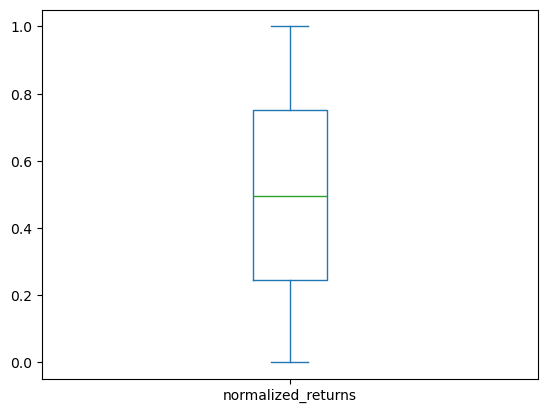

In [8]:
df['normalized_returns'].plot.box();

# Remove Duplicate Rows: 

Remove duplicate rows that have the same 'Fund' and 'Date' values.

The `drop_duplicates()` method has a parameter named "subset" that allows us to drop duplicates but only consider a specific set of columns.

In [9]:
clean = df.drop_duplicates(subset=['Fund', 'Date'])

clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18839 entries, 0 to 26457
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Fund                18839 non-null  object        
 1   Date                18839 non-null  datetime64[ns]
 2   Returns             18803 non-null  float64       
 3   Assets              18839 non-null  int32         
 4   Strategy            18839 non-null  object        
 5   Volatility          18839 non-null  float64       
 6   Returns_ffill       18839 non-null  float64       
 7   normalized_returns  18839 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int32(1), object(2)
memory usage: 1.2+ MB


# Summary:  
The tutorial demonstrates how to clean and prepare financial data for analysis. It starts with a messy dataset of hedge funds' daily returns, assets, strategy, and volatility. The data is cleaned by filling missing values, normalizing returns data, and removing duplicate rows.

### Key Takeaways:  
- **Fill missing values:** Use the `ffill` method to fill missing values in a column, especially when the missing values are a result of no trading activity.
- **Normalize data:** Use the formula (returns - returns.min()) / (returns.max() - returns.min()) to normalize data to a range of 0 to 1.
- **Remove duplicates:** Use the `drop_duplicates` method with the subset parameter to remove duplicate rows based on specific columns.
- **Data types:** Be aware of the data types in each column and convert them as needed (e.g., from object to float64).
- **GroupBy:** Use the groupby method to perform operations on groups of data (e.g., filling missing values for each fund).

<p class="text-muted">This tutorial was created by <a href="https://www.hedaro.com" target="_blank"><strong>HEDARO</strong></a></p>